# Altermagnetic superconductors

In [1]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from amsc import impurity_system, bulk_amsc_system 
from plot_tools import add_tl_label, complex_plot
from scipy.interpolate import RegularGridInterpolator
from tqdm.notebook import tqdm
from pauli import *
from qm_tools import thermal_broadening

In [2]:
eigsh = sla.eigsh


# Uncomment to activate MUMPS

import mumps

def sparse_diag(matrix, k, sigma, **kwargs):
    """Call sla.eigsh with mumps support.

    See scipy.sparse.linalg.eigsh for documentation.
    """
    class LuInv(sla.LinearOperator):
        def __init__(self, A):
            inst = mumps.Context()
            inst.analyze(A, ordering='pord')
            inst.factor(A)
            self.solve = inst.solve
            sla.LinearOperator.__init__(self, A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    opinv = LuInv(matrix - sigma * sp.identity(matrix.shape[0]))
    return sla.eigsh(matrix, k, sigma=sigma, OPinv=opinv, **kwargs)

eigsh = sparse_diag

In [3]:
#plt.style.use("../plot_style.mplstyle")

# System Setup

In [4]:
periodic_bc = False

Nx = 101
Ny = 101

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 5.0
t_so = 0.0
t_am = 0.4 * t

mu = 0.3 * t # 2 * t  
hz0 = 1e-6
hx0 = 0
hy0 = 0

# Temperature
T = 0.01

# Select the number of eigenvalues to calculate (it will set the energy cutoff)
N = 60

# Self consistency loops
Nloops = 0

# Sparse or dense diagonalization
sparse = True

## Initial value for Delta (will be used to determine g)
Delta_init = 1

In [5]:
eta = t_am / t
omega_mg = Delta_init - eta * mu
print(f"The minigap is located at {omega_mg}")

The minigap is located at 0.3999999999999999


In [6]:
# Impurituy or vortex positions
impurity_positions =  [(23, 0)]#, (-10, 0)]

In [7]:
winding = [0, 0]  
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Psi_n = Delta_init + 0j * x

if l_core != 0:
    for n, pos in enumerate(impurity_positions):
        xp, yp = pos
        Psi_n *= (1 - np.exp(-np.sqrt((x - xp) ** 2 + (y - yp) ** 2) / l_core)) * np.exp(1j * winding[n] * np.arctan2(y-yp, x-xp))

# Create the new interpolation functions
Delta_interp = RegularGridInterpolator((y_ax, x_ax), abs(Psi_n))
theta_interp = RegularGridInterpolator((y_ax, x_ax), np.angle(Psi_n))

# Update the order parameter
Delta = lambda x, y: Delta_interp((y, x))
theta = lambda x, y: theta_interp((y, x))

In [8]:
# Parameters for the impurities
s_imp = [3, 3]  # Sizes
ec_imp = [0.0, 0.8]  # Eccentricity
ph_imp = [0, np.pi / 4]  # Orientation

hx_imp = [0, 0]  # Impurity field
hy_imp = [0, 0]  # Impurity field
hz_imp = [0, 0]  # Impurity field
V_imp = [-1.5 * t, -1.5 * t]  # Impurity potential (negative = attractive)

# Calculation of the A matrix for each Gaussian potential
A_matrices = []
for sigma, e, alpha in zip(s_imp, ec_imp, ph_imp):
    R = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
    Sigma = sigma**2 / 2 * np.array(
        [[np.sqrt(1 - e**2), 0], [0, np.sqrt(1 + e**2)]]
    )
    Sigma_prime = R @ Sigma @ R.T
    A = np.linalg.inv(Sigma_prime) / 2
    A_matrices.append(A)


# Fields definition
def V(x, y):
    V = -mu + 0 * x
    for i, pos in enumerate(impurity_positions):
        xp, yp = pos
        r = np.array([x - xp, y - yp])
        V += V_imp[i] * np.exp(-np.einsum("aij, ab, bij -> ij", r, A_matrices[i], r)) # / (2 * np.pi) * np.sqrt(la.det(2*A_matrices[i]))
    return V


def hx(x, y):
    hx = hx0 + 0 * x
    for i, pos in enumerate(impurity_positions):
        xp, yp = pos
        r = np.array([x - xp, y - yp])
        hx += hx_imp[i] * np.exp(-np.einsum("aij, ab, bij -> ij", r, A_matrices[i], r)) # / (2 * np.pi) * np.sqrt(la.det(2*A_matrices[i]))
    return hx


def hy(x, y):
    hy = hy0 + 0 * x
    for i, pos in enumerate(impurity_positions):
        xp, yp = pos
        r = np.array([x - xp, y - yp])
        hy += hy_imp[i] * np.exp(-np.einsum("aij, ab, bij -> ij", r, A_matrices[i], r)) # / (2 * np.pi) * np.sqrt(la.det(2*A_matrices[i]))
    return hy


def hz(x, y):
    hz = hx0 + 0 * x
    for i, pos in enumerate(impurity_positions):
        xp, yp = pos
        r = np.array([x - xp, y - yp])
        hz += hz_imp[i] * np.exp(-np.einsum("aij, ab, bij -> ij", r, A_matrices[i], r)) # / (2 * np.pi) * np.sqrt(la.det(2*A_matrices[i]))
    return hz


# Create the new interpolation functions
V_interp = RegularGridInterpolator((y_ax, x_ax), V(x, y))
hx_interp = RegularGridInterpolator((y_ax, x_ax), hx(x, y))
hy_interp = RegularGridInterpolator((y_ax, x_ax), hy(x, y))
hz_interp = RegularGridInterpolator((y_ax, x_ax), hz(x, y))

V = lambda x, y: V_interp((y, x))
hx = lambda x, y: hx_interp((y, x))
hy = lambda x, y: hy_interp((y, x))
hz = lambda x, y: hz_interp((y, x))

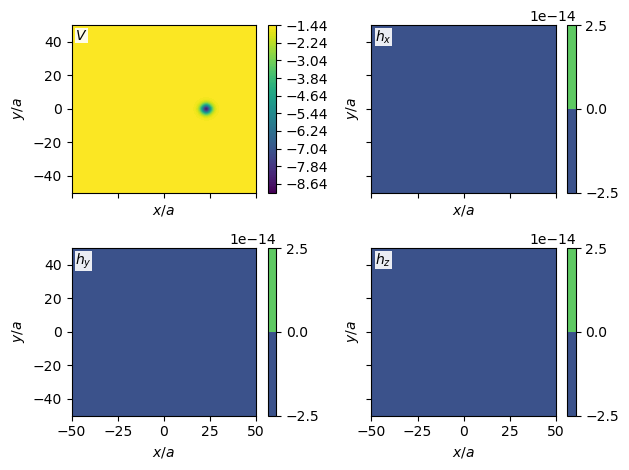

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)

# Plot for V(x, y)
im1 = axs[0, 0].contourf(x, y, V(x, y), levels=100)
add_tl_label(
    axs[0, 0],
    r"$V$",
)
axs[0, 0].set_xlabel(r"$x/a$")
axs[0, 0].set_ylabel(r"$y/a$")

# Plot for hx(x, y)
im2 = axs[0, 1].contourf(x, y, hx(x, y))
add_tl_label(axs[0, 1], r"$h_x$")
axs[0, 1].set_xlabel(r"$x/a$")
axs[0, 1].set_ylabel(r"$y/a$")

# Plot for hy(x, y)
im3 = axs[1, 0].contourf(x, y, hy(x, y))
add_tl_label(axs[1, 0], r"$h_y$")
axs[1, 0].set_xlabel(r"$x/a$")
axs[1, 0].set_ylabel(r"$y/a$")

# Plot for hz(x, y)
im4 = axs[1, 1].contourf(x, y, hz(x, y))
add_tl_label(axs[1, 1], r"$h_z$")
axs[1, 1].set_xlabel(r"$x/a$")
axs[1, 1].set_ylabel(r"$y/a$")

fig.colorbar(im1)
fig.colorbar(im2)
fig.colorbar(im3)
fig.colorbar(im4)

fig.tight_layout()

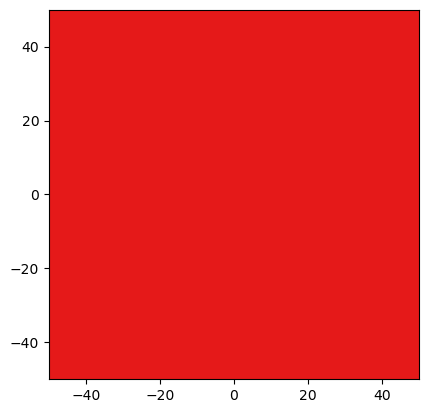

In [10]:
# Show the order parameter
fig, ax, im = complex_plot(x, y, Delta(x, y) * np.exp(1j * theta(x, y)))

In [11]:
# ## IMPURITY
# t_prime = 1.0 * t
# t_so_prime = 1.0 * t_so
# t_am_prime = 1.0 * t_am


# def create_system(Delta, theta):
#     syst, lat = impurity_system(
#         Nx=Nx,
#         Ny=Ny,
#         t=t,
#         t_so=t_so,
#         t_am=t_am,
#         V=V,
#         Delta=Delta,
#         theta=theta,
#         hx=hx,
#         hy=hy,
#         hz=hz,
#         periodic_bc=periodic_bc,
#         t_prime=t_prime,
#         t_so_prime=t_so_prime,
#         t_am_prime=t_am_prime,
#         impurity_positions=impurity_positions,
#     )

#     return syst.finalized()

In [12]:
def create_system(Delta, theta):
    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
        )

    return syst.finalized()

In [13]:
fsyst = create_system(Delta, theta)

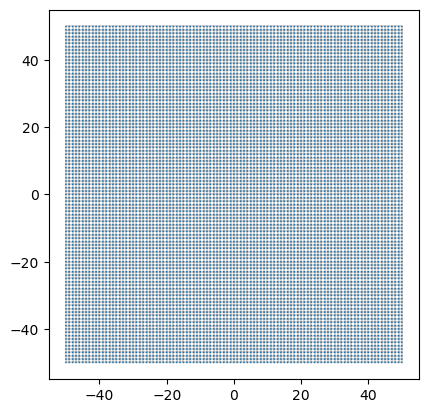

In [14]:
kwant.plot(fsyst);

In [15]:
# Quasiparticle density
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)

# Electric charge
tzs0_op = kwant.operator.Density(fsyst, onsite=tzs0, sum=False)

# Spin
tzsx_op = kwant.operator.Density(fsyst, onsite=tzsx, sum=False)
tzsy_op = kwant.operator.Density(fsyst, onsite=tzsy, sum=False)
tzsz_op = kwant.operator.Density(fsyst, onsite=tzsz, sum=False)

# Singlet correlations
txs0_op = kwant.operator.Density(fsyst, onsite=txs0, sum=False)
tys0_op = kwant.operator.Density(fsyst, onsite=tys0, sum=False)

# Triplet correlations
txsx_op = kwant.operator.Density(fsyst, onsite=txsx, sum=False)
tysx_op = kwant.operator.Density(fsyst, onsite=tysx, sum=False)
txsy_op = kwant.operator.Density(fsyst, onsite=txsy, sum=False)
tysy_op = kwant.operator.Density(fsyst, onsite=tysy, sum=False)
txsz_op = kwant.operator.Density(fsyst, onsite=txsz, sum=False)
tysz_op = kwant.operator.Density(fsyst, onsite=tysz, sum=False)

# Currents
j_t0s0_op = kwant.operator.Current(fsyst, onsite=t0s0)
j_tzs0_op = kwant.operator.Current(fsyst, onsite=tzs0)
j_tzsz_op = kwant.operator.Current(fsyst, onsite=tzsz)

# Exact diagonalization

## Self-consistency

We first diagonalize the system once and by comparing the triplet correlations simulated with the original delta, we deterimne
the coupling constant $g$. Then we exectue the same diagonalization and update of the order parameter for$N_\mathrm{loops}$ times keeping $g$ fixed.

In [16]:
%%time

if sparse == True:
    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0) 

else:
    ws, vs = la.eigh(fsyst.hamiltonian_submatrix())
    N = 4 * Nx * Ny

sort_idxs = np.argsort(ws)
vs = vs[:, sort_idxs]
ws = ws[sort_idxs]

omega_cutoff = ws[-1]

CPU times: user 1min 49s, sys: 1.77 s, total: 1min 51s
Wall time: 17 s


In [17]:
print(f"The energy cutoff is {omega_cutoff:5.3f}")

if omega_cutoff < Delta_init + eta*mu:
    print("Warning: cutoff too low!")

The energy cutoff is 0.387


In [18]:
txs0_ev = np.zeros((N, Nx * Ny))
tys0_ev = np.zeros((N, Nx * Ny))
for i in range(N):
    txs0_ev[i] = txs0_op(vs[:, i])
    tys0_ev[i] = tys0_op(vs[:, i])

Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))

g = Delta_init / np.mean(np.sqrt(Fx**2 + Fy**2))

Delta_n = g * np.sqrt(Fx**2 + Fy**2)
theta_n = np.arctan2(Fy, Fx)

print(f"The coupling constant is {g:5.3f}")

The coupling constant is 205.214


In [19]:
diff = np.mean((Delta_n.reshape(Ny, Nx) - Delta(x, y)) ** 2)
diff

0.3642234246211472

In [20]:
Delta_interp = RegularGridInterpolator((y_ax, x_ax), Delta_n.reshape(Ny, Nx))
theta_interp = RegularGridInterpolator((y_ax, x_ax), theta_n.reshape(Ny, Nx))

Delta = lambda x, y: Delta_interp((y, x))
theta = lambda x, y: theta_interp((y, x))

In [21]:
mixing = 0.5

for iter_number in range(Nloops):
    # Create a new system with the new order parameter
    fsyst = create_system(
        Delta=Delta,
        theta=theta,
    )

    # Diagonalize the sytem
    if sparse == True:
        ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0) 
    else:
        ws, vs = la.eigh(fsyst.hamiltonian_submatrix())
        
    sort_idxs = np.argsort(ws)
    vs = vs[:, sort_idxs]
    ws = ws[sort_idxs]

    # Calculate correlation functions
    txs0_ev = np.zeros((N, Nx * Ny))
    tys0_ev = np.zeros((N, Nx * Ny))
    for i in range(N):
        txs0_ev[i] = txs0_op(vs[:, i])
        tys0_ev[i] = tys0_op(vs[:, i])

    Fx = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T)))
    Fy = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T)))

    # Calculate the order parameter
    Delta_n_new = g * np.sqrt(Fx**2 + Fy**2)
    theta_n_new = np.arctan2(Fy, Fx)

    Delta_n = (1-mixing)*Delta_n + mixing*Delta_n_new
    theta_n = (1-mixing)*theta_n + mixing*Delta_n_new
    
    diff = np.mean((Delta_n.reshape(Nx, Ny) - Delta(x, y)) ** 2)
    print(f"Iteration {iter_number:2d}, the average error is: {diff:5f}")

    # Create the new interpolation functions
    Delta_interp = RegularGridInterpolator((y_ax, x_ax), Delta_n.reshape(Ny, Nx))
    theta_interp = RegularGridInterpolator((y_ax, x_ax), theta_n.reshape(Ny, Nx))

    # Update the order parameter
    Delta = lambda x, y: Delta_interp((y, x))
    theta = lambda x, y: theta_interp((y, x))

## Analysis of anomalous correlations

In [22]:
# Calculate correlation functions
txs0_ev = np.zeros((N, Nx * Ny))
tys0_ev = np.zeros((N, Nx * Ny))
txsx_ev = np.zeros((N, Nx * Ny))
tysx_ev = np.zeros((N, Nx * Ny))
txsy_ev = np.zeros((N, Nx * Ny))
tysy_ev = np.zeros((N, Nx * Ny))
txsz_ev = np.zeros((N, Nx * Ny))
tysz_ev = np.zeros((N, Nx * Ny))

for i in range(N):
    txs0_ev[i] = txs0_op(vs[:, i])
    tys0_ev[i] = tys0_op(vs[:, i])

    txsx_ev[i] = txsx_op(vs[:, i])
    tysx_ev[i] = tysx_op(vs[:, i])

    txsy_ev[i] = txsy_op(vs[:, i])
    tysy_ev[i] = tysy_op(vs[:, i])

    txsz_ev[i] = txsz_op(vs[:, i])
    tysz_ev[i] = tysz_op(vs[:, i])

F0_re = np.einsum("ni, n -> i", txs0_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
F0_im = np.einsum("ni, n -> i", tys0_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fx_re = np.einsum("ni, n -> i", txsx_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fx_im = np.einsum("ni, n -> i", tysx_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fy_re = np.einsum("ni, n -> i", txsy_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fy_im = np.einsum("ni, n -> i", tysy_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fz_re = np.einsum("ni, n -> i", txsz_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T
Fz_im = np.einsum("ni, n -> i", tysz_ev, np.tanh(ws / (2 * T))).reshape(Nx, Ny).T

F0_abs = np.sqrt(F0_re**2 + F0_im**2)
F0_theta = np.arctan2(F0_im, F0_re)
Fx_abs = np.sqrt(Fx_re**2 + Fx_im**2)
Fx_theta = np.arctan2(Fx_im, Fx_re)
Fy_abs = np.sqrt(Fy_re**2 + Fy_im**2)
Fy_theta = np.arctan2(Fy_im, Fy_re)
Fz_abs = np.sqrt(Fy_re**2 + Fy_im**2)
Fz_theta = np.arctan2(Fy_im, Fy_re)

In [23]:
F0_abs.max()

0.0905225834606753

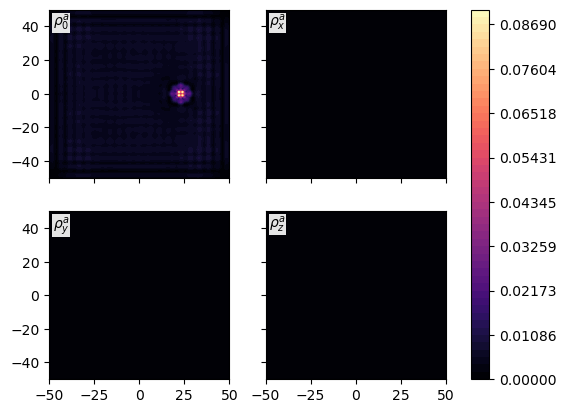

In [24]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
im00 = axs[0, 0].contourf(
    x, y, F0_abs, cmap="magma", levels=np.linspace(0, 1, 51) * F0_abs.max()
)
axs[0, 1].contourf(
    x, y, Fx_abs, cmap="magma", levels=np.linspace(0, 1, 51) * F0_abs.max()
)
axs[1, 0].contourf(
    x, y, Fy_abs, cmap="magma", levels=np.linspace(0, 1, 51) * F0_abs.max()
)
axs[1, 1].contourf(
    x, y, Fz_abs, cmap="magma", levels=np.linspace(0, 1, 51) * F0_abs.max()
)

cbar00 = fig.colorbar(im00, ax=axs, location="right")

add_tl_label(axs[0, 0], r"$\rho^a_0$")
add_tl_label(axs[0, 1], r"$\rho^a_x$")
add_tl_label(axs[1, 0], r"$\rho^a_y$")
add_tl_label(axs[1, 1], r"$\rho^a_z$")

(<Figure size 640x480 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fc74f5d0050>)

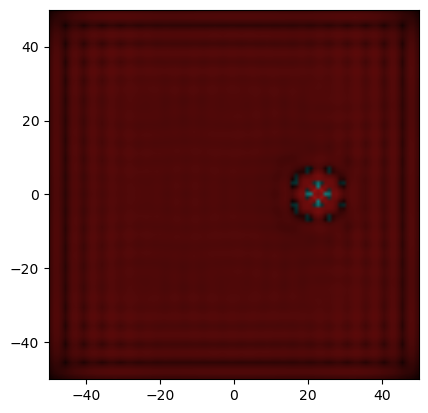

In [25]:
complex_plot(x, y, F0_abs * np.exp(1j * F0_theta))

In [26]:
Delta_init = Delta_n.mean()

/home/andmai/workspace/amvortex/tightbinding/qm_tools.py:43: RuntimeWarning: overflow encountered in cosh
  return y_f(e - x * T) / (2 * (1 + np.cosh(x)))
/home/andmai/workspace/amvortex/tightbinding/qm_tools.py:43: RuntimeWarning: overflow encountered in multiply
  return y_f(e - x * T) / (2 * (1 + np.cosh(x)))


(-0.1, 10.0)

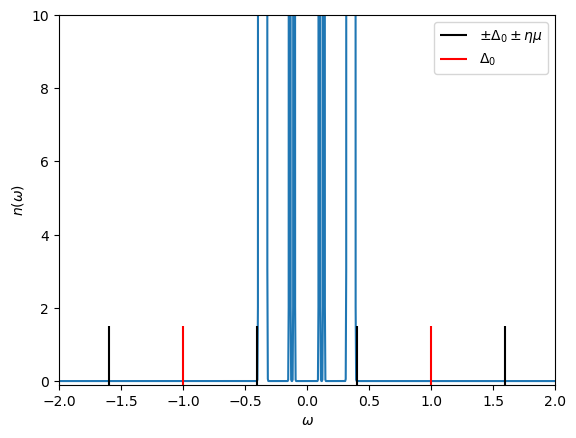

In [27]:
T_spectrum=0.001

e_ax = np.linspace(-Delta_init*2, +Delta_init*2, 1001)
de = e_ax[1]-e_ax[0]

dos, _ = np.histogram(ws, bins = e_ax)
dos = dos/de
dost = thermal_broadening(e_ax[:-1], dos, T=T_spectrum)

fig, ax = plt.subplots()
ax.plot(e_ax[:-1], dost)
ax.set_xlabel(r"$\omega$")
ax.set_ylabel(r"$n(\omega)$")

#ax.set_xlim([omega_cutoff, -omega_cutoff])

ax.vlines([-Delta_init-eta*mu, -Delta_init+eta*mu, +Delta_init-eta*mu, +Delta_init+eta*mu], -0.25, 1.5, colors="k", label=r"$\pm\Delta_0\pm\eta\mu$")
ax.vlines([-Delta_init, Delta_init],-0.25, 1.5, colors="r", label=r"$\Delta_0$")

#ax.vlines([-omega_cutoff, omega_cutoff], -0.5, 0.5, colors="g", label=r"$\omega_{c}$")
ax.legend()

ax.set_xlim(-2, 2)
ax.set_ylim(-0.1, 10)

## Single states analysis

In [28]:
# Select the subgap state to analyze
idx = len(ws) // 2 

In [29]:
ws[idx:idx+4]

array([0.10362254, 0.10366078, 0.13762941, 0.13773516])

Text(0, 0.5, 'Energy')

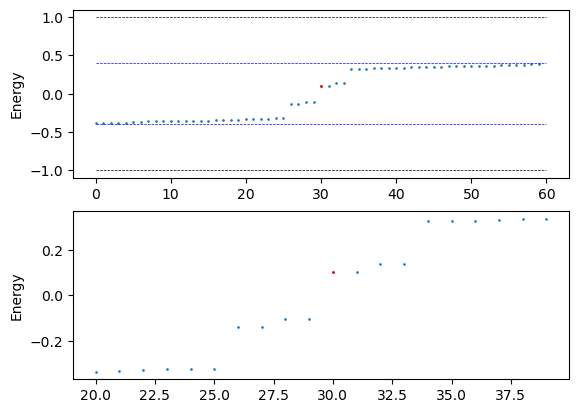

In [30]:
fig, (ax1, ax2) = plt.subplots(nrows=2)

ax1.scatter(np.arange(len(ws)), ws, s=0.8)
ax1.scatter(idx, ws[idx], c="r", s=0.8)
ax1.set_ylabel(r"Energy")
ax1.hlines([-Delta_init, Delta_init], 0, N, color='k', linestyles='--', linewidth=0.5)
ax1.hlines([-omega_mg, omega_mg], 0, N, color='b', linestyles='--', linewidth=0.5)


ax2.scatter(np.arange(idx-10, idx+10), ws[idx-10: idx+10], s=0.8)
ax2.scatter(idx, ws[idx], c="r", s=0.8)
ax2.set_ylabel(r"Energy")


In [31]:
# Calculate the densities
t0s0_d = t0s0_op(vs[:, idx])
t0sz_d = t0sz_op(vs[:, idx])
tzs0_d = tzs0_op(vs[:, idx])
tzsz_d = tzsz_op(vs[:, idx])

txs0_d = txs0_op(vs[:, idx])
tys0_d = tys0_op(vs[:, idx])
txsx_d = txsx_op(vs[:, idx])
txsy_d = txsy_op(vs[:, idx])
txsz_d = txsz_op(vs[:, idx])
tysx_d = tysx_op(vs[:, idx])
tysy_d = tysy_op(vs[:, idx])
tysz_d = tysz_op(vs[:, idx])

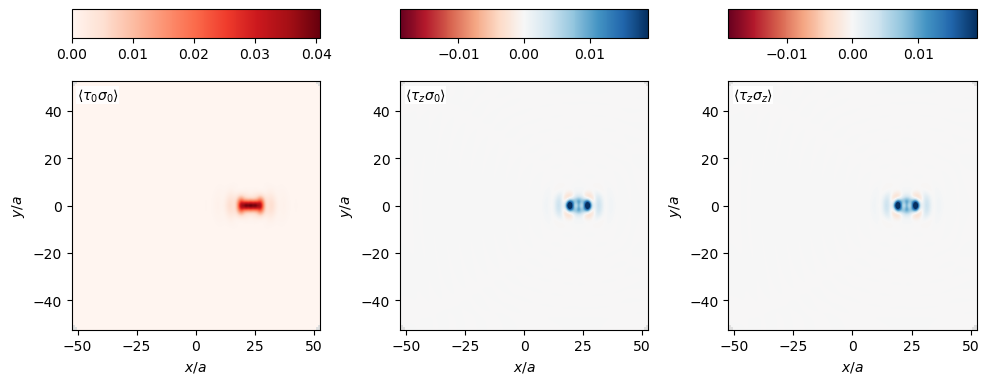

In [32]:
# Your existing code
fig = plt.figure(figsize=(10, 4))
gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.1, 1])

ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])

cax1 = plt.subplot(gs[0, 0])
cax2 = plt.subplot(gs[0, 1])
cax3 = plt.subplot(gs[0, 2])

im1 = kwant.plotter.density(fsyst, t0s0_d, ax=ax1, cmap="Reds", colorbar=cax1)
im2 = kwant.plotter.density(
    fsyst, tzs0_d, ax=ax2, cmap="RdBu", vmin=-abs(tzs0_d).max(), vmax=+abs(tzs0_d).max()
)
im3 = kwant.plotter.density(
    fsyst, tzsz_d, ax=ax3, cmap="RdBu", vmin=-abs(tzsz_d).max(), vmax=+abs(tzsz_d).max()
)

cbar1 = plt.colorbar(ax1.images[0], cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(ax2.images[0], cax=cax2, orientation="horizontal")
cbar3 = plt.colorbar(ax3.images[0], cax=cax3, orientation="horizontal")

add_tl_label(ax1, r"$\langle \tau_0 \sigma_0 \rangle$")
add_tl_label(ax2, r"$\langle \tau_z \sigma_0 \rangle$")
add_tl_label(ax3, r"$\langle \tau_z \sigma_z \rangle$")

ax1.set_xlabel(r"$x/a$")
ax2.set_xlabel(r"$x/a$")
ax3.set_xlabel(r"$x/a$")

ax1.set_ylabel(r"$y/a$")
ax2.set_ylabel(r"$y/a$")
ax3.set_ylabel(r"$y/a$")

fig.tight_layout()

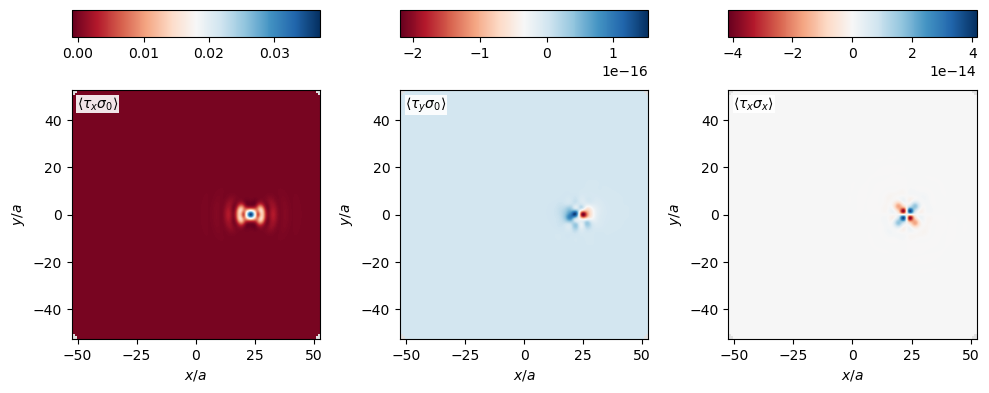

In [33]:
fig = plt.figure(figsize=(10, 4))
gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.1, 1])

ax1 = plt.subplot(gs[1, 0])
ax2 = plt.subplot(gs[1, 1])
ax3 = plt.subplot(gs[1, 2])

cax1 = plt.subplot(gs[0, 0])
cax2 = plt.subplot(gs[0, 1])
cax3 = plt.subplot(gs[0, 2])

im1 = kwant.plotter.density(fsyst, txs0_d, ax=ax1, cmap="RdBu", colorbar=cax1)
im2 = kwant.plotter.density(fsyst, tys0_d, ax=ax2, cmap="RdBu")
im3 = kwant.plotter.density(fsyst, txsx_d, ax=ax3, cmap="RdBu")

cbar1 = plt.colorbar(ax1.images[0], cax=cax1, orientation="horizontal")
cbar2 = plt.colorbar(ax2.images[0], cax=cax2, orientation="horizontal")
cbar3 = plt.colorbar(ax3.images[0], cax=cax3, orientation="horizontal")

# Add labels to the top-left corner of each plot

add_tl_label(ax1, r"$\langle \tau_x \sigma_0 \rangle$")
add_tl_label(ax2, r"$\langle \tau_y \sigma_0 \rangle$")
add_tl_label(ax3, r"$\langle \tau_x \sigma_x \rangle$")

ax1.set_xlabel(r"$x/a$")
ax2.set_xlabel(r"$x/a$")
ax3.set_xlabel(r"$x/a$")

ax1.set_ylabel(r"$y/a$")
ax2.set_ylabel(r"$y/a$")
ax3.set_ylabel(r"$y/a$")

fig.tight_layout()

## Composite plots

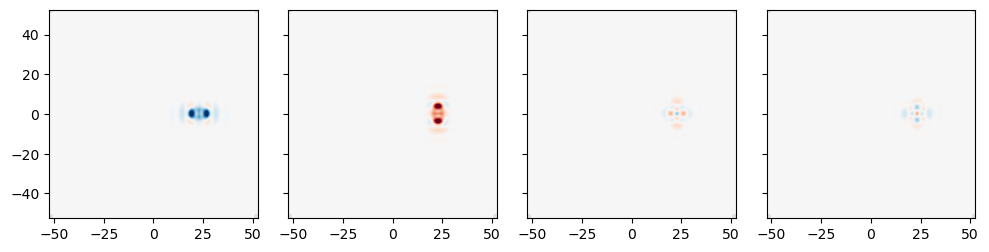

In [34]:
idx = len(ws) //2

d_1 = tzsz_op(vs[:, idx+0])
d_2 = tzsz_op(vs[:, idx+1])
d_3 = tzsz_op(vs[:, idx+2])
d_4 = tzsz_op(vs[:, idx+3])

fig, axs = plt.subplots(1, 4, sharex = True, sharey=True, figsize = (10, 5))

kwant.plotter.density(fsyst, d_1, ax=axs[0], cmap="RdBu", vmin=-abs(d_1).max(), vmax=+abs(d_1).max())
kwant.plotter.density(fsyst, d_2, ax=axs[1], cmap="RdBu", vmin=-abs(d_2).max(), vmax=+abs(d_2).max())
kwant.plotter.density(fsyst, d_3, ax=axs[2], cmap="RdBu", vmin=-abs(d_3).max(), vmax=+abs(d_3).max())
kwant.plotter.density(fsyst, d_4, ax=axs[3], cmap="RdBu", vmin=-abs(d_4).max(), vmax=+abs(d_4).max())

fig.tight_layout()

In [35]:
Delta_n

array([0.00708115, 0.02348046, 0.04121544, ..., 0.04661693, 0.02584367,
       0.00765722])

In [36]:
[d_1.sum(),
d_2.sum(),
d_3.sum(),
d_4.sum()]

[0.342884548576153,
 -0.3446058450782204,
 -0.07517002782561372,
 0.07569188703570413]

In [37]:
abs(V(x, y) - np.rot90(V(x, y))).max()

7.5

### Currents

In [38]:
j_t0s0 = j_t0s0_op(vs[:, idx])
j_tzs0 = j_tzs0_op(vs[:, idx])
j_tzsz = j_tzsz_op(vs[:, idx])

(-35.0, 35.0)

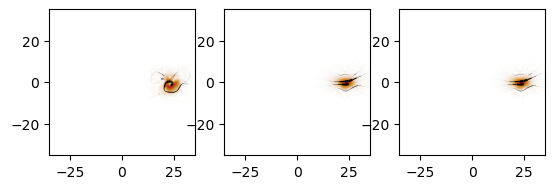

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

im1 = kwant.plotter.current(
    fsyst, j_t0s0, ax=ax1, colorbar=True, min_linewidth=0.1, max_linewidth=2
)
im2 = kwant.plotter.current(
    fsyst, j_tzs0, ax=ax2, colorbar=True, min_linewidth=0.1, max_linewidth=2
)
im3 = kwant.plotter.current(
    fsyst, j_tzsz, ax=ax3, colorbar=True, min_linewidth=0.1, max_linewidth=2
)

ax1.set_xlim(-35, 35)
ax1.set_ylim(-35, 35)

ax2.set_xlim(-35, 35)
ax2.set_ylim(-35, 35)

ax3.set_xlim(-35, 35)
ax3.set_ylim(-35, 35)